In [1]:
import cobra
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import graph_utils as gu
from optlang.symbolics import Zero
from itertools import chain, combinations_with_replacement
import networkx as nx
import json
from amg_utils import amg_limits

In [2]:
masses = json.loads(open("model_files/masses.json").read())
manual_relabels = json.loads(open("model_files/subsystem_alias.json").read())
amgs = json.loads(open("model_files/amg_reactions.json").read())

In [3]:
model = cobra.io.read_sbml_model("./model_files/ProchlorococcusMED4+PHM2v1.xml")

In [4]:
def nearest_ind(df, v):
    return min(range(len(df.index)), key=lambda x: abs(df.index[x] - v))


def flux_at_val(df, v):
    return df.iloc[nearest_ind(df, v), 0].fluxes

In [5]:
with model as host_model:
    h_fva = cobra.flux_analysis.flux_variability_analysis(
        host_model,
        [
            host_model.reactions.AmmoniaEX,
            host_model.reactions.FAKEOrthophosphateEX,
            host_model.reactions.HCO3EXcar,
            host_model.reactions.LightEX,
        ],
    )
with model as phage_model:
    phage_model.objective = phage_model.reactions.PHM2_prodrxn_VN.flux_expression
    p_fva = cobra.flux_analysis.flux_variability_analysis(
        phage_model,
        [
            phage_model.reactions.AmmoniaEX,
            phage_model.reactions.FAKEOrthophosphateEX,
            phage_model.reactions.HCO3EXcar,
            phage_model.reactions.LightEX,
        ],
    )

print("Host-optimal")
print(h_fva)
print()
print("Phage-optimal")
print(p_fva)

Host-optimal
                          minimum    maximum
AmmoniaEX               -0.864117  -0.855149
FAKEOrthophosphateEX    -0.033099  -0.033099
HCO3EXcar            -1000.000000  -5.341752
LightEX              -1000.000000 -72.510110

Phage-optimal
                          minimum    maximum
AmmoniaEX               -1.637692  -1.637692
FAKEOrthophosphateEX    -0.187383  -0.187383
HCO3EXcar            -1000.000000  -4.917245
LightEX              -1000.000000 -56.503374


Based on the above, we will set some (highly permissive) bounds on maximum nutrient uptake

In [6]:
BOUND_FACTOR = 5
N_LIMIT = -0.86 * BOUND_FACTOR
P_LIMIT = -0.18 * BOUND_FACTOR
C_LIMIT = -5.4 * BOUND_FACTOR
L_LIMIT = -73 * BOUND_FACTOR

In [7]:
def amg_impact_by_parsimony(
    model,
    amgs,
    optimum_tolerance=0.5,
    new_amg_penalty=0,
):
    with model as imodel:
        biomass = imodel.slim_optimize()
        imodel.reactions.BIOMASS.lower_bound = biomass * (1 - optimum_tolerance)

        # Do not allow the cell to uptake too much to feed prioritized reactions
        imodel.reactions.AmmoniaEX.bounds = (
            N_LIMIT,
            0,
        )
        imodel.reactions.FAKEOrthophosphateEX.bounds = (
            P_LIMIT,
            0,
        )
        imodel.reactions.HCO3EXcar.bounds = (
            C_LIMIT,
            0,
        )
        imodel.reactions.LightEX.bounds = (
            L_LIMIT,
            0,
        )

        # parsimony only applies to gene-regulated reactions here
        rxn_list = [rxn for rxn in imodel.reactions if rxn.genes or rxn.id in amgs]

        reaction_variables = (
            (rxn.forward_variable, rxn.reverse_variable) for rxn in rxn_list
        )
        reaction_is_doubled = ((rxn.id, rxn.id) for rxn in rxn_list)
        id_var = zip(chain(*reaction_is_doubled), chain(*reaction_variables))

        # Infected
        imodel.objective = imodel.problem.Objective(
            Zero, direction="min", sloppy=True, name="_pfba_objective"
        )

        coeff = {}
        forward = True
        for rid, v in id_var:
            if rid in amgs and amgs[rid] == "raw increase":
                if forward:
                    coeff[v] = 1.0 - abs(new_amg_penalty)
                else:
                    coeff[v] = 1.0 + abs(new_amg_penalty)
            elif rid in amgs and amgs[rid] == "raw decrease":
                if forward:
                    coeff[v] = 1.0 + abs(new_amg_penalty)
                else:
                    coeff[v] = 1.0 - abs(new_amg_penalty)
            elif rid in amgs and amgs[rid] == "absolute increase":
                if forward:
                    coeff[v] = 1.0 - abs(new_amg_penalty)
                else:
                    coeff[v] = 1.0 - abs(new_amg_penalty)
            elif rid in amgs and amgs[rid] == "absolute decrease":
                if forward:
                    coeff[v] = 1.0 + abs(new_amg_penalty)
                else:
                    coeff[v] = 1.0 + abs(new_amg_penalty)
            else:
                coeff[v] = 1.0
            forward = not forward
        imodel.objective.set_linear_coefficients(coeff)
        infected = imodel.optimize()

        return infected


def draw_graph(
    gs, ax, manual_relabels=None, cut=0.3, pos=None, scale=1, label_rotation=15
):
    if manual_relabels is None:
        manual_relabels = {}
    gs_red = gs.edge_subgraph(
        [(u, v) for u, v, d in gs.edges(data=True) if np.abs(d["weight"] / scale) > cut]
    )

    if pos is None:
        pos = nx.shell_layout(gs_red)
    nx.draw_networkx_nodes(
        gs_red,
        pos=pos,
        ax=ax,
        alpha=0.5,
        node_size=[
            50 * np.sqrt(np.abs(gs.in_degree(n, weight="weight") / scale))
            for n in gs_red.nodes
        ],
        node_color=[
            "#aaaaff" if gs.in_degree(n, weight="weight") > 0 else "#ffaaaa"
            for n in gs_red.nodes
        ],
    )

    # draw node labels by hand becasue nx.draw_networkx_labels can't rotate labels
    for label, (x, y) in pos.items():
        if label not in gs_red.nodes():
            continue
        if label in manual_relabels:
            lab = manual_relabels[label]
        else:
            lab = label
        ax.text(
            x,
            y,
            lab,
            fontsize=12,
            ha="center",
            va="center",
            rotation=label_rotation,
        )

    nx.draw_networkx_edges(
        gs_red,
        pos=pos,
        edge_color=[
            "#aaaaff" if d["weight"] > 0 else "#ffaaaa"
            for _, _, d in gs_red.edges(data=True)
        ],
        alpha=[
            min((np.abs(d["weight"] / scale) / 100) ** (1 / 4), 1)
            for _, _, d in gs_red.edges(data=True)
        ],
        connectionstyle="arc3, rad = 0.1",
        arrowsize=20,
        width=[
            np.log(np.abs(d["weight"] / scale)) for _, _, d in gs_red.edges(data=True)
        ],
        ax=ax,
    )
    ax.set_frame_on(False)

In [8]:
baselines = []
infecteds = []
diffs = []
penalties = np.linspace(0, 10, 111)
baseline = amg_impact_by_parsimony(model, amgs, new_amg_penalty=0)
for amg_penalty in penalties:
    infected = amg_impact_by_parsimony(model, amgs, new_amg_penalty=-amg_penalty)
    diff = infected.fluxes - baseline.fluxes
    baselines.append(baseline)
    infecteds.append(infected)
    diffs.append(diff)

baselines = pd.DataFrame(baselines, index=penalties)
infecteds = pd.DataFrame(infecteds, index=penalties)

absdiffs = pd.DataFrame(
    [
        infected.fluxes.abs() - baseline.fluxes.abs()
        for infected, baseline in zip(
            infecteds.values.flatten(), baselines.values.flatten()
        )
    ],
    index=penalties,
)

diffs = pd.DataFrame(diffs, index=penalties)
diffs

R01055  R00546        R05605  R00346        R00355  R00357  \
0.000000      0.0     0.0  2.442491e-14     0.0  3.136380e-15     0.0   
0.090909      0.0     0.0  2.031708e-14     0.0 -4.596323e-14     0.0   
0.181818      0.0     0.0  2.031708e-14     0.0 -4.596323e-14     0.0   
0.272727      0.0     0.0  2.031708e-14     0.0 -4.596323e-14     0.0   
0.363636      0.0     0.0  2.031708e-14     0.0 -4.596323e-14     0.0   
...           ...     ...           ...     ...           ...     ...   
9.636364      0.0     0.0  3.108624e-14     0.0  1.054712e-14     0.0   
9.727273      0.0     0.0  3.108624e-14     0.0  1.054712e-14     0.0   
9.818182      0.0     0.0  3.108624e-14     0.0  1.054712e-14     0.0   
9.909091      0.0     0.0  3.108624e-14     0.0  1.054712e-14     0.0   
10.000000     0.0     0.0  3.108624e-14     0.0  1.054712e-14     0.0   

                 R00369        R00485        R00489        R00768  ...  \
0.000000  -7.806256e-16  1.630640e-16  1.377479e-16  1.153591e-16  ...   
0.090909  -6.522560e-16  1.361758e-16  6.884684e-17  9.714451e-17  ...   
0.181818  -6.522560e-16  1.361758e-16  6.884684e-17  9.714451e-17  ...   
0.272727  -6.522560e-16  1.361758e-16  6.884684e-17  9.714451e-17  ...   
0.363636  -6.522560e-16  1.361758e-16  6.884684e-17  9.714451e-17  ...   
...                 ...           ...           ...           ...  ...   
9.636364  -1.037365e-15  2.168404e-16  0.000000e+00  1.539567e-16  ...   
9.727273  -1.037365e-15  2.168404e-16  0.000000e+00  1.539567e-16  ...   
9.818182  -1.037365e-15  2.168404e-16  0.000000e+00  1.539567e-16  ...   
9.909091  -1.037365e-15  2.168404e-16  0.000000e+00  1.539567e-16  ...   
10.000000 -1.037365e-15  2.168404e-16  0.000000e+00  1.539567e-16  ...   

           R05681  R04439  R02097  Trans_S_Malate  S_MalateEX  R01078  \
0.000000      0.0     0.0     0.0             0.0         0.0     0.0   
0.090909      0.0     0.0     0.0             0.0         0.0     0.0   
0.181818      0.0     0.0     0.0             0.0         0.0     0.0   
0.272727      0.0     0.0     0.0             0.0         0.0     0.0   
0.363636      0.0     0.0     0.0             0.0         0.0     0.0   
...           ...     ...     ...             ...         ...     ...   
9.636364      0.0     0.0     0.0             0.0         0.0     0.0   
9.727273      0.0     0.0     0.0             0.0         0.0     0.0   
9.818182      0.0     0.0     0.0             0.0         0.0     0.0   
9.909091      0.0     0.0     0.0             0.0         0.0     0.0   
10.000000     0.0     0.0     0.0             0.0         0.0     0.0   

             Trans_H2O2        H2O2EX        R02036  PHM2_prodrxn_VN  
0.000000  -1.043436e-15 -1.043436e-15  2.431388e-14              0.0  
0.090909  -3.580469e-15 -3.580469e-15  2.020606e-14              0.0  
0.181818  -3.580469e-15 -3.580469e-15  2.020606e-14              0.0  
0.272727  -3.580469e-15 -3.580469e-15  2.020606e-14              0.0  
0.363636  -3.580469e-15 -3.580469e-15  2.020606e-14              0.0  
...                 ...           ...           ...              ...  
9.636364   6.947568e-16  6.947568e-16  3.108624e-14              0.0  
9.727273   6.947568e-16  6.947568e-16  3.108624e-14              0.0  
9.818182   6.947568e-16  6.947568e-16  3.108624e-14              0.0  
9.909091   6.947568e-16  6.947568e-16  3.108624e-14              0.0  
10.000000  6.947568e-16  6.947568e-16  3.108624e-14              0.0  

[111 rows x 995 columns]

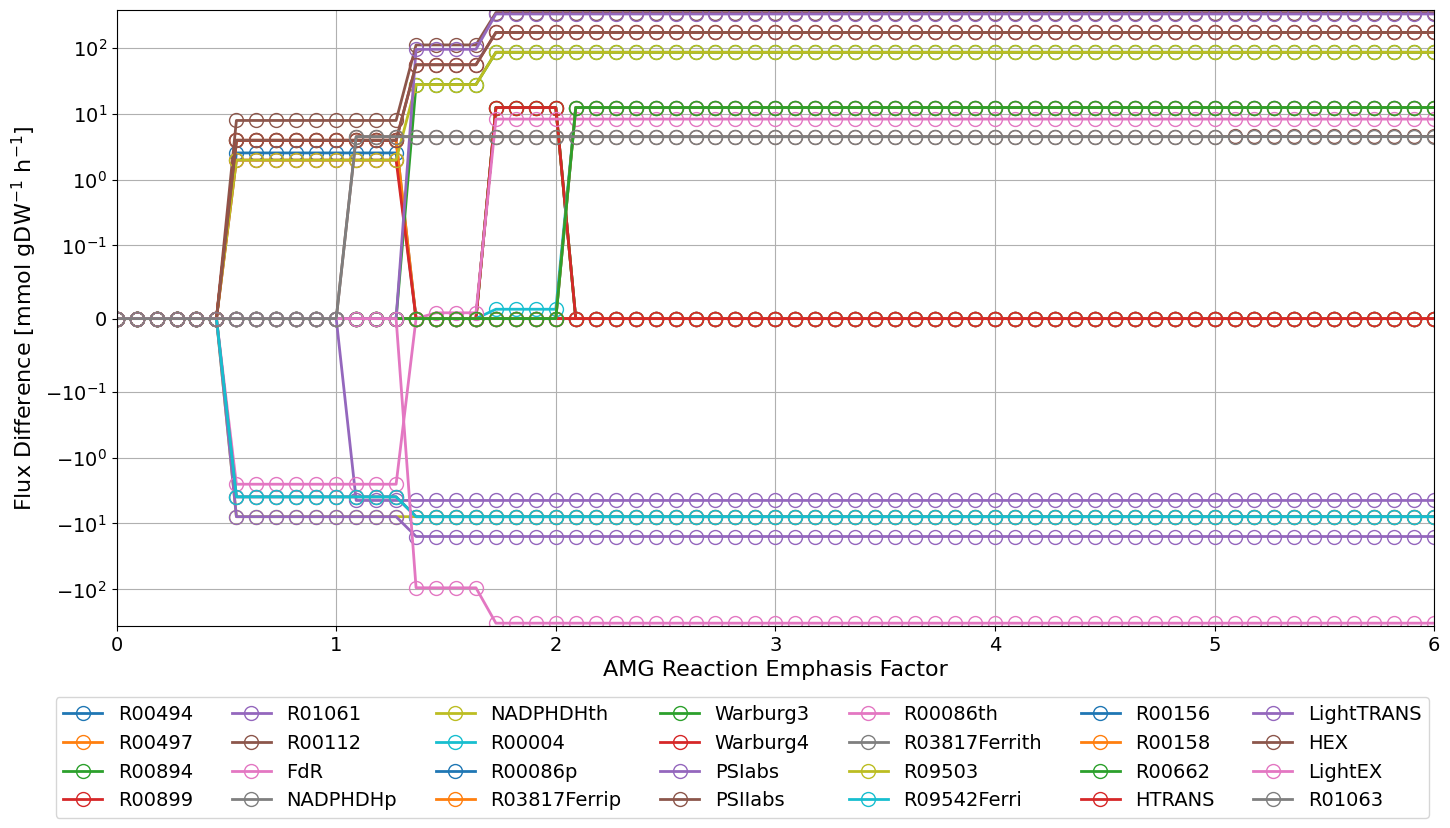

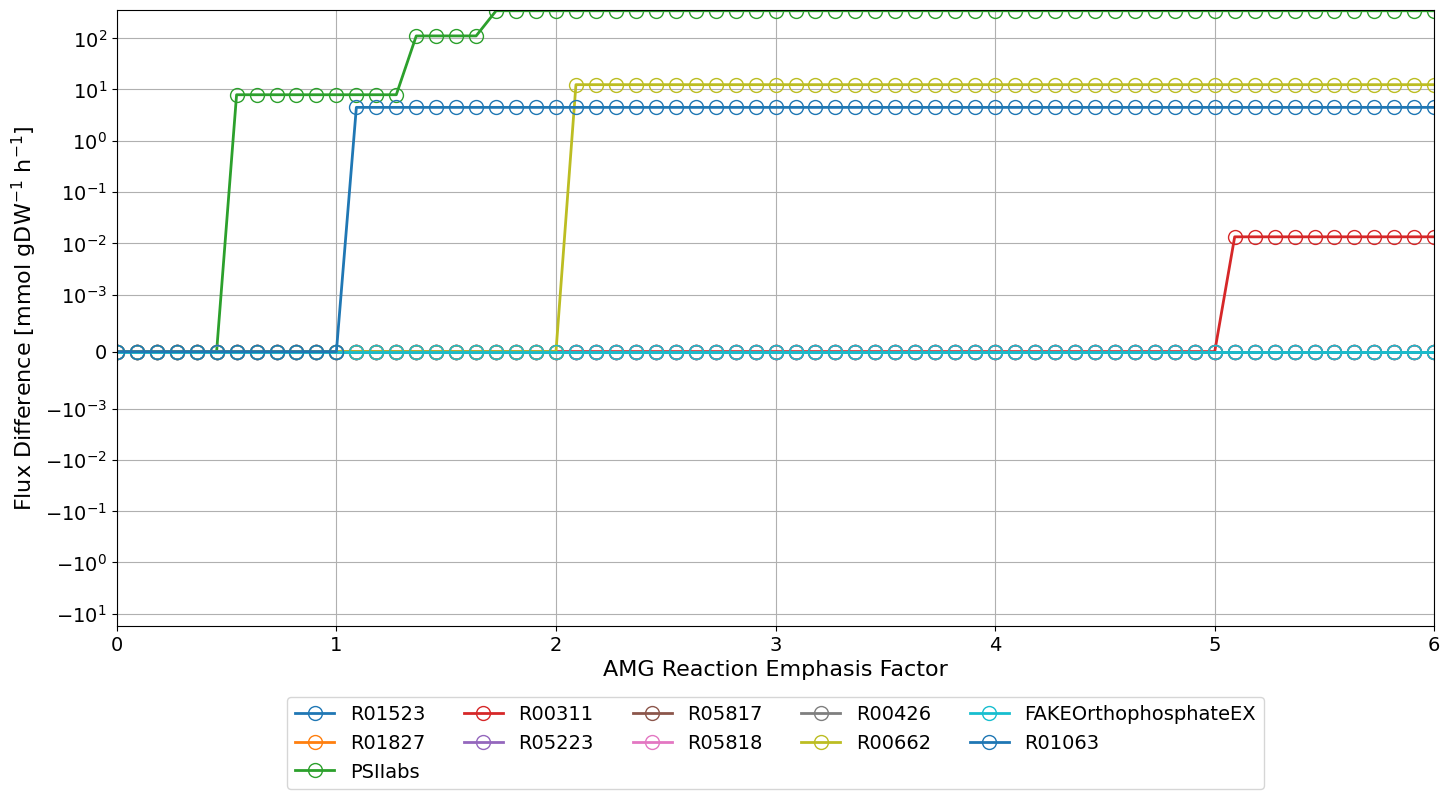

In [9]:
ax = diffs[[col for col in diffs.columns if (diffs[col].abs().max() > 0.1)]].plot(
    figsize=(17, 8),
    marker="o",
    fillstyle="none",
    linewidth=2,
    markersize=10,
)
ax.set_yscale("symlog", linthresh=1e-1)
plt.tick_params(labelsize=14)
ax.legend(ncols=7, loc="upper center", bbox_to_anchor=(0.475, -0.1), fontsize=14)
ax.set_xlim(0, 6)
ax.set_xlabel("AMG Reaction Emphasis Factor", fontsize=16)
ax.set_ylabel(r"Flux Difference [mmol gDW$^{-1}$ h$^{-1}$]", fontsize=16)
ax.grid(True, which="both")
plt.show()
ax = (
    diffs[[col for col in absdiffs.columns if (col in amgs)]]
    # * np.random.uniform(0.9, 1.1, (len(diffs), 10)) # uncomment to add noise to check for overlap
).plot(
    figsize=(17, 8),
    marker="o",
    fillstyle="none",
    linewidth=2,
    markersize=10,
)
ax.set_yscale("symlog", linthresh=1e-3)
plt.tick_params(labelsize=14)
ax.legend(ncols=5, loc="upper center", bbox_to_anchor=(0.5, -0.1), fontsize=14)
ax.set_xlim(0, 6)
ax.set_xlabel("AMG Reaction Emphasis Factor", fontsize=16)
ax.set_ylabel(r"Flux Difference [mmol gDW$^{-1}$ h$^{-1}$]", fontsize=16)
ax.grid(True, which="both")
plt.show()

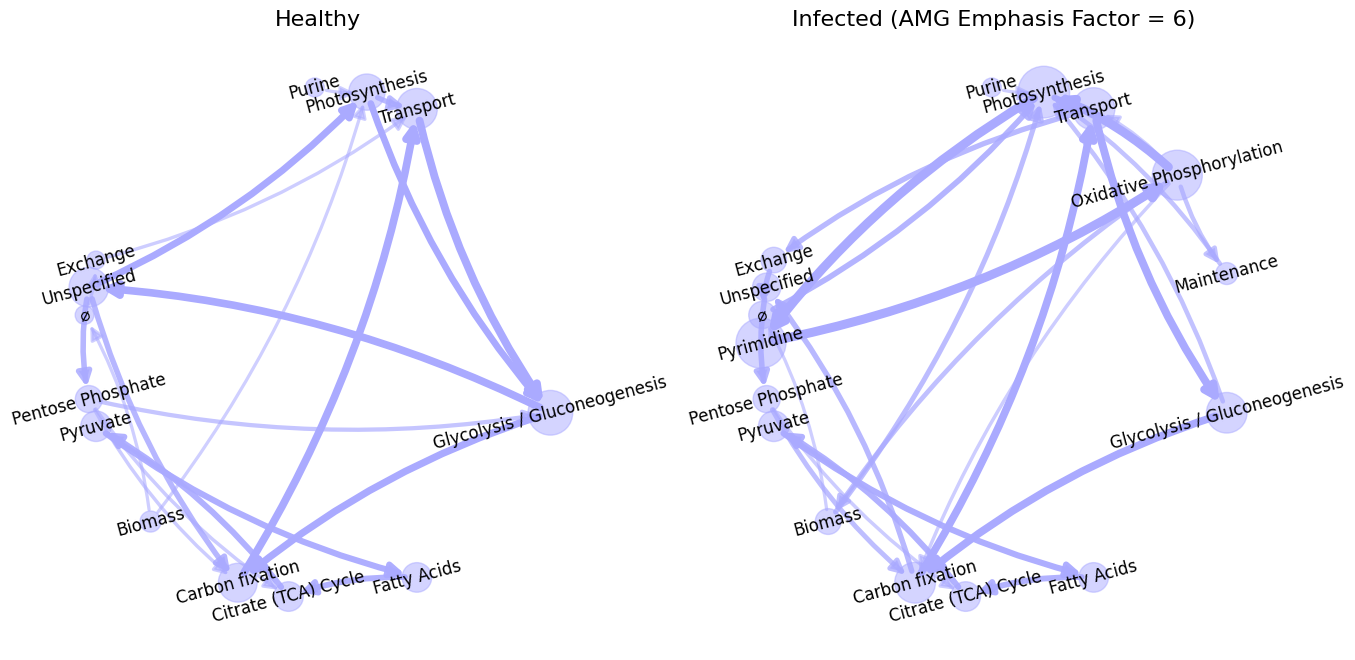

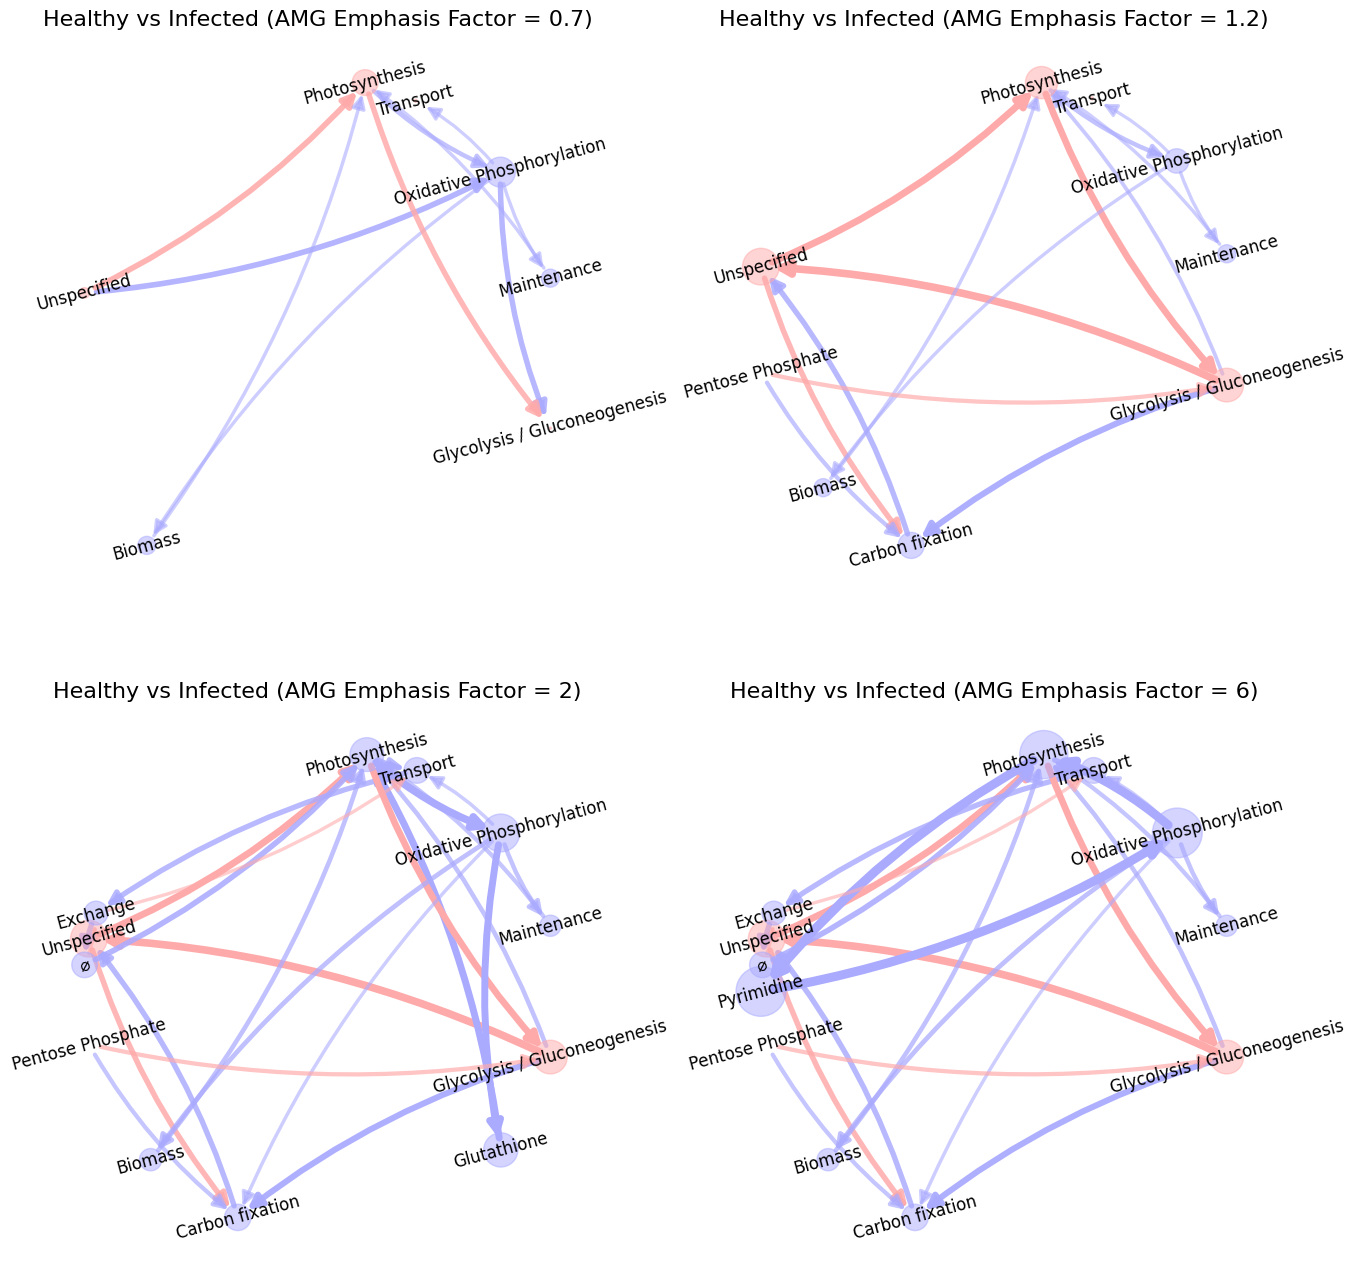

In [10]:
factor = 6
scale = 3
cut = 30 / scale
g_healthy = gu.subsystem_flux_graph(
    model,
    flux_at_val(baselines, factor),
    masses=masses,
)
g_infected = gu.subsystem_flux_graph(
    model,
    flux_at_val(infecteds, factor),
    masses=masses,
)
pos = nx.shell_layout(g_infected)
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
draw_graph(
    g_healthy, axs[0], manual_relabels=manual_relabels, scale=scale, pos=pos, cut=cut
)
draw_graph(
    g_infected, axs[1], manual_relabels=manual_relabels, scale=scale, pos=pos, cut=cut
)
axs[0].set_title("Healthy", fontsize=16)
axs[1].set_title(f"Infected (AMG Emphasis Factor = {factor})", fontsize=16)
plt.show()

fig, axs = plt.subplots(2, 2, figsize=(16, 16))
flist = [0.7, 1.2, 2, 6]

# pos = None
pg = nx.DiGraph()
for r in range(2):
    for ax, factor in zip(axs.flatten(), flist):
        g_healthy = gu.subsystem_flux_graph(
            model,
            flux_at_val(baselines, factor),
            masses=masses,
        )
        g_infected = gu.subsystem_flux_graph(
            model,
            flux_at_val(infecteds, factor),
            masses=masses,
        )

        g_diff = gu.diff_graph(g_infected, g_healthy)

        gs_red = g_diff.edge_subgraph(
            [
                (u, v)
                for u, v, d in g_diff.edges(data=True)
                if np.abs(d["weight"] / scale) > cut
            ]
        )
        if r:
            if pos is None:
                pos = nx.shell_layout(pg)
            draw_graph(
                g_diff,
                ax,
                cut=cut,
                manual_relabels=manual_relabels,
                pos=pos,
                scale=scale,
            )
            ax.set_title(
                f"Healthy vs Infected (AMG Emphasis Factor = {factor})", fontsize=16
            )
        else:
            pg.add_edges_from(gs_red.edges())
plt.show()

In [11]:
sys_diffs_in = {}
for factor in penalties:
    g_infected = gu.subsystem_flux_graph(
        model,
        flux_at_val(infecteds, factor),
        masses=masses,
    )
    g_healthy = gu.subsystem_flux_graph(
        model,
        flux_at_val(baselines, factor),
        masses=masses,
    )

    g_diff = gu.diff_graph(g_infected, g_healthy)
    # g_diff = g_healthy
    # g_diff = g_infected
    if "AMG Emphasis Factor" in sys_diffs_in:
        sys_diffs_in["AMG Emphasis Factor"].append(factor)
    else:
        sys_diffs_in["AMG Emphasis Factor"] = [factor]
    for u in g_diff.nodes():
        deg = g_diff.in_degree(u, weight="weight")
        if u in sys_diffs_in:
            sys_diffs_in[u].append(deg / 1000)
        else:
            sys_diffs_in[u] = [deg / 1000]

sys_diffs_in = pd.DataFrame(sys_diffs_in)
sys_diffs_in.columns = [manual_relabels.get(u, u) for u in sys_diffs_in.columns]


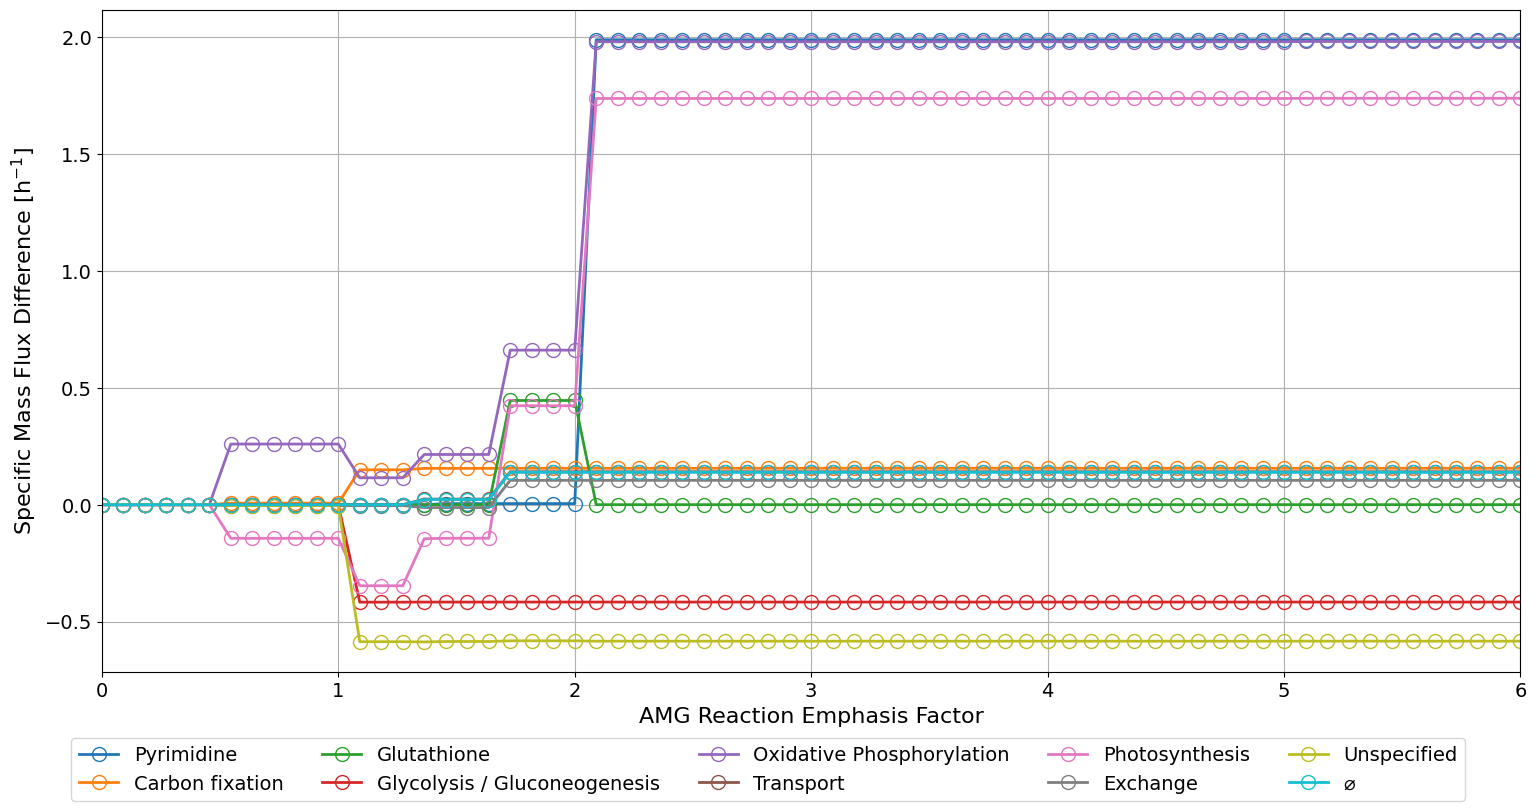

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8), sharex=True)

ax = sys_diffs_in[
    [
        col
        for col in sys_diffs_in.columns
        if (sys_diffs_in[col].abs().max() > 0.1) or "AMG" in col
    ]
].plot(
    x="AMG Emphasis Factor",
    marker="o",
    fillstyle="none",
    ax=ax,
    legend=False,
    linewidth=2,
    markersize=10,
)
# ax.set_yscale("symlog")
ax.tick_params(labelsize=14)
fig.legend(ncols=5, loc="upper center", bbox_to_anchor=(0.5, 0.05), fontsize=14)
ax.set_xlim(0, 6)
ax.set_xlabel("AMG Reaction Emphasis Factor", fontsize=16)
ax.set_ylabel(
    r"Specific Mass Flux Difference [h$^{-1}$]",
    fontsize=16,
)
ax.grid(True, which="both")

fig.tight_layout(pad=3.0)
plt.show()

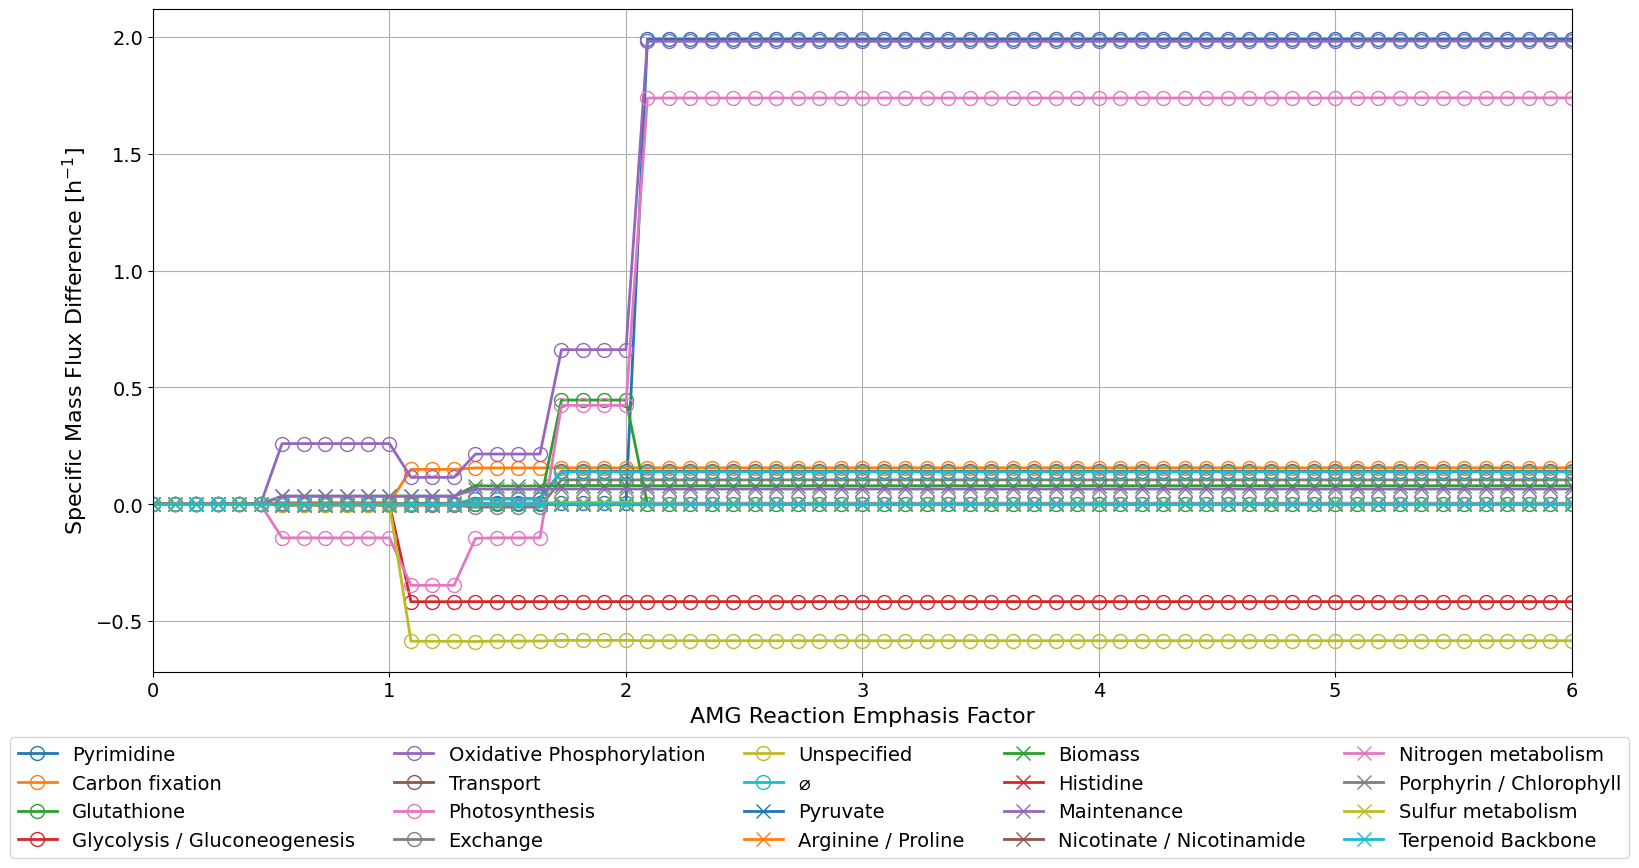

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8), sharex=True)

ax = sys_diffs_in[
    [
        col
        for col in sys_diffs_in.columns
        if (sys_diffs_in[col].abs().max() > 0.1) or "AMG" in col
    ]
].plot(
    x="AMG Emphasis Factor",
    marker="o",
    fillstyle="none",
    ax=ax,
    legend=False,
    linewidth=2,
    markersize=10,
)

ax = sys_diffs_in[
    [
        col
        for col in sys_diffs_in.columns
        if (0.100 >= sys_diffs_in[col].abs().max() > 0.001) or "AMG" in col
    ]
].plot(
    x="AMG Emphasis Factor",
    marker="x",
    fillstyle="none",
    ax=ax,
    legend=False,
    linewidth=2,
    markersize=10,
)
# ax.set_yscale("symlog", linthresh=0.01)
ax.tick_params(labelsize=14)
fig.legend(ncols=5, loc="upper center", bbox_to_anchor=(0.5, 0.05), fontsize=14)
ax.set_xlim(0, 6)
ax.set_xlabel("AMG Reaction Emphasis Factor", fontsize=16)
ax.set_ylabel(
    r"Specific Mass Flux Difference [h$^{-1}$]",
    fontsize=16,
)
ax.grid(True, which="both")

fig.tight_layout(pad=3.0)
plt.show()

In [14]:
amgs

{'FAKEOrthophosphateEX': 'raw decrease',
 'PSIIabs': 'raw increase',
 'R00311': 'raw increase',
 'R00426': 'raw increase',
 'R00662': 'raw increase',
 'R01063': 'absolute decrease',
 'R01523': 'absolute decrease',
 'R01827': 'absolute increase',
 'R05223': 'raw increase',
 'R05817': 'raw increase',
 'R05818': 'raw increase'}

In [15]:
permissive_fva = cobra.flux_analysis.flux_variability_analysis(
    model, fraction_of_optimum=0.0
)

In [16]:
amg_limits_dict = {}
with model as phm2:
    phm2.objective = phm2.reactions.PHM2_prodrxn_VN
    for amg, direction in amgs.items():
        amg_limits_dict[amg] = amg_limits(
            phm2, amg, direction, tol=0.1, optimum_fraction=0.5
        )

FAKEOrthophosphateEX FAKEOrthophosphateEX optimal
FAKEOrthophosphateEX PSIIabs optimal
FAKEOrthophosphateEX R00311 optimal
FAKEOrthophosphateEX R00426 optimal
FAKEOrthophosphateEX R00662 optimal
FAKEOrthophosphateEX R01063 optimal
FAKEOrthophosphateEX R01523 optimal
FAKEOrthophosphateEX R01827 optimal
FAKEOrthophosphateEX R05223 optimal
FAKEOrthophosphateEX R05817 optimal
FAKEOrthophosphateEX R05818 optimal
PSIIabs PSIIabs optimal
PSIIabs R00311 optimal


c:\Users\rozu775\Documents\Code\nwbrave\hm2-amgs-in-med4\.venv\Lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


PSIIabs R00426 infeasible
PSIIabs R00662 infeasible
PSIIabs R01063 optimal
PSIIabs R01523 optimal
PSIIabs R01827 optimal
PSIIabs R05223 optimal
PSIIabs R05817 optimal
PSIIabs R05818 optimal
R00311 R00311 optimal
R00311 R00426 infeasible
R00311 R00662 infeasible
R00311 R01063 optimal
R00311 R01523 optimal
R00311 R01827 optimal
R00311 R05223 optimal
R00311 R05817 optimal
R00311 R05818 optimal
R00426 R00426 optimal
R00426 R00662 infeasible
R00426 R01063 optimal
R00426 R01523 optimal
R00426 R01827 optimal
R00426 R05223 optimal
R00426 R05817 optimal
R00426 R05818 optimal
R00662 R00662 optimal
R00662 R01063 optimal
R00662 R01523 optimal
R00662 R01827 optimal
R00662 R05223 optimal
R00662 R05817 optimal
R00662 R05818 optimal
R01063 R01063 optimal
R01063 R01523 optimal
R01063 R01827 optimal
R01063 R05223 optimal
R01063 R05817 optimal
R01063 R05818 optimal
R01523 R01523 optimal
R01523 R01827 infeasible
R01523 R05223 optimal
R01523 R05817 optimal
R01523 R05818 optimal
R01827 R01827 optimal
R01827

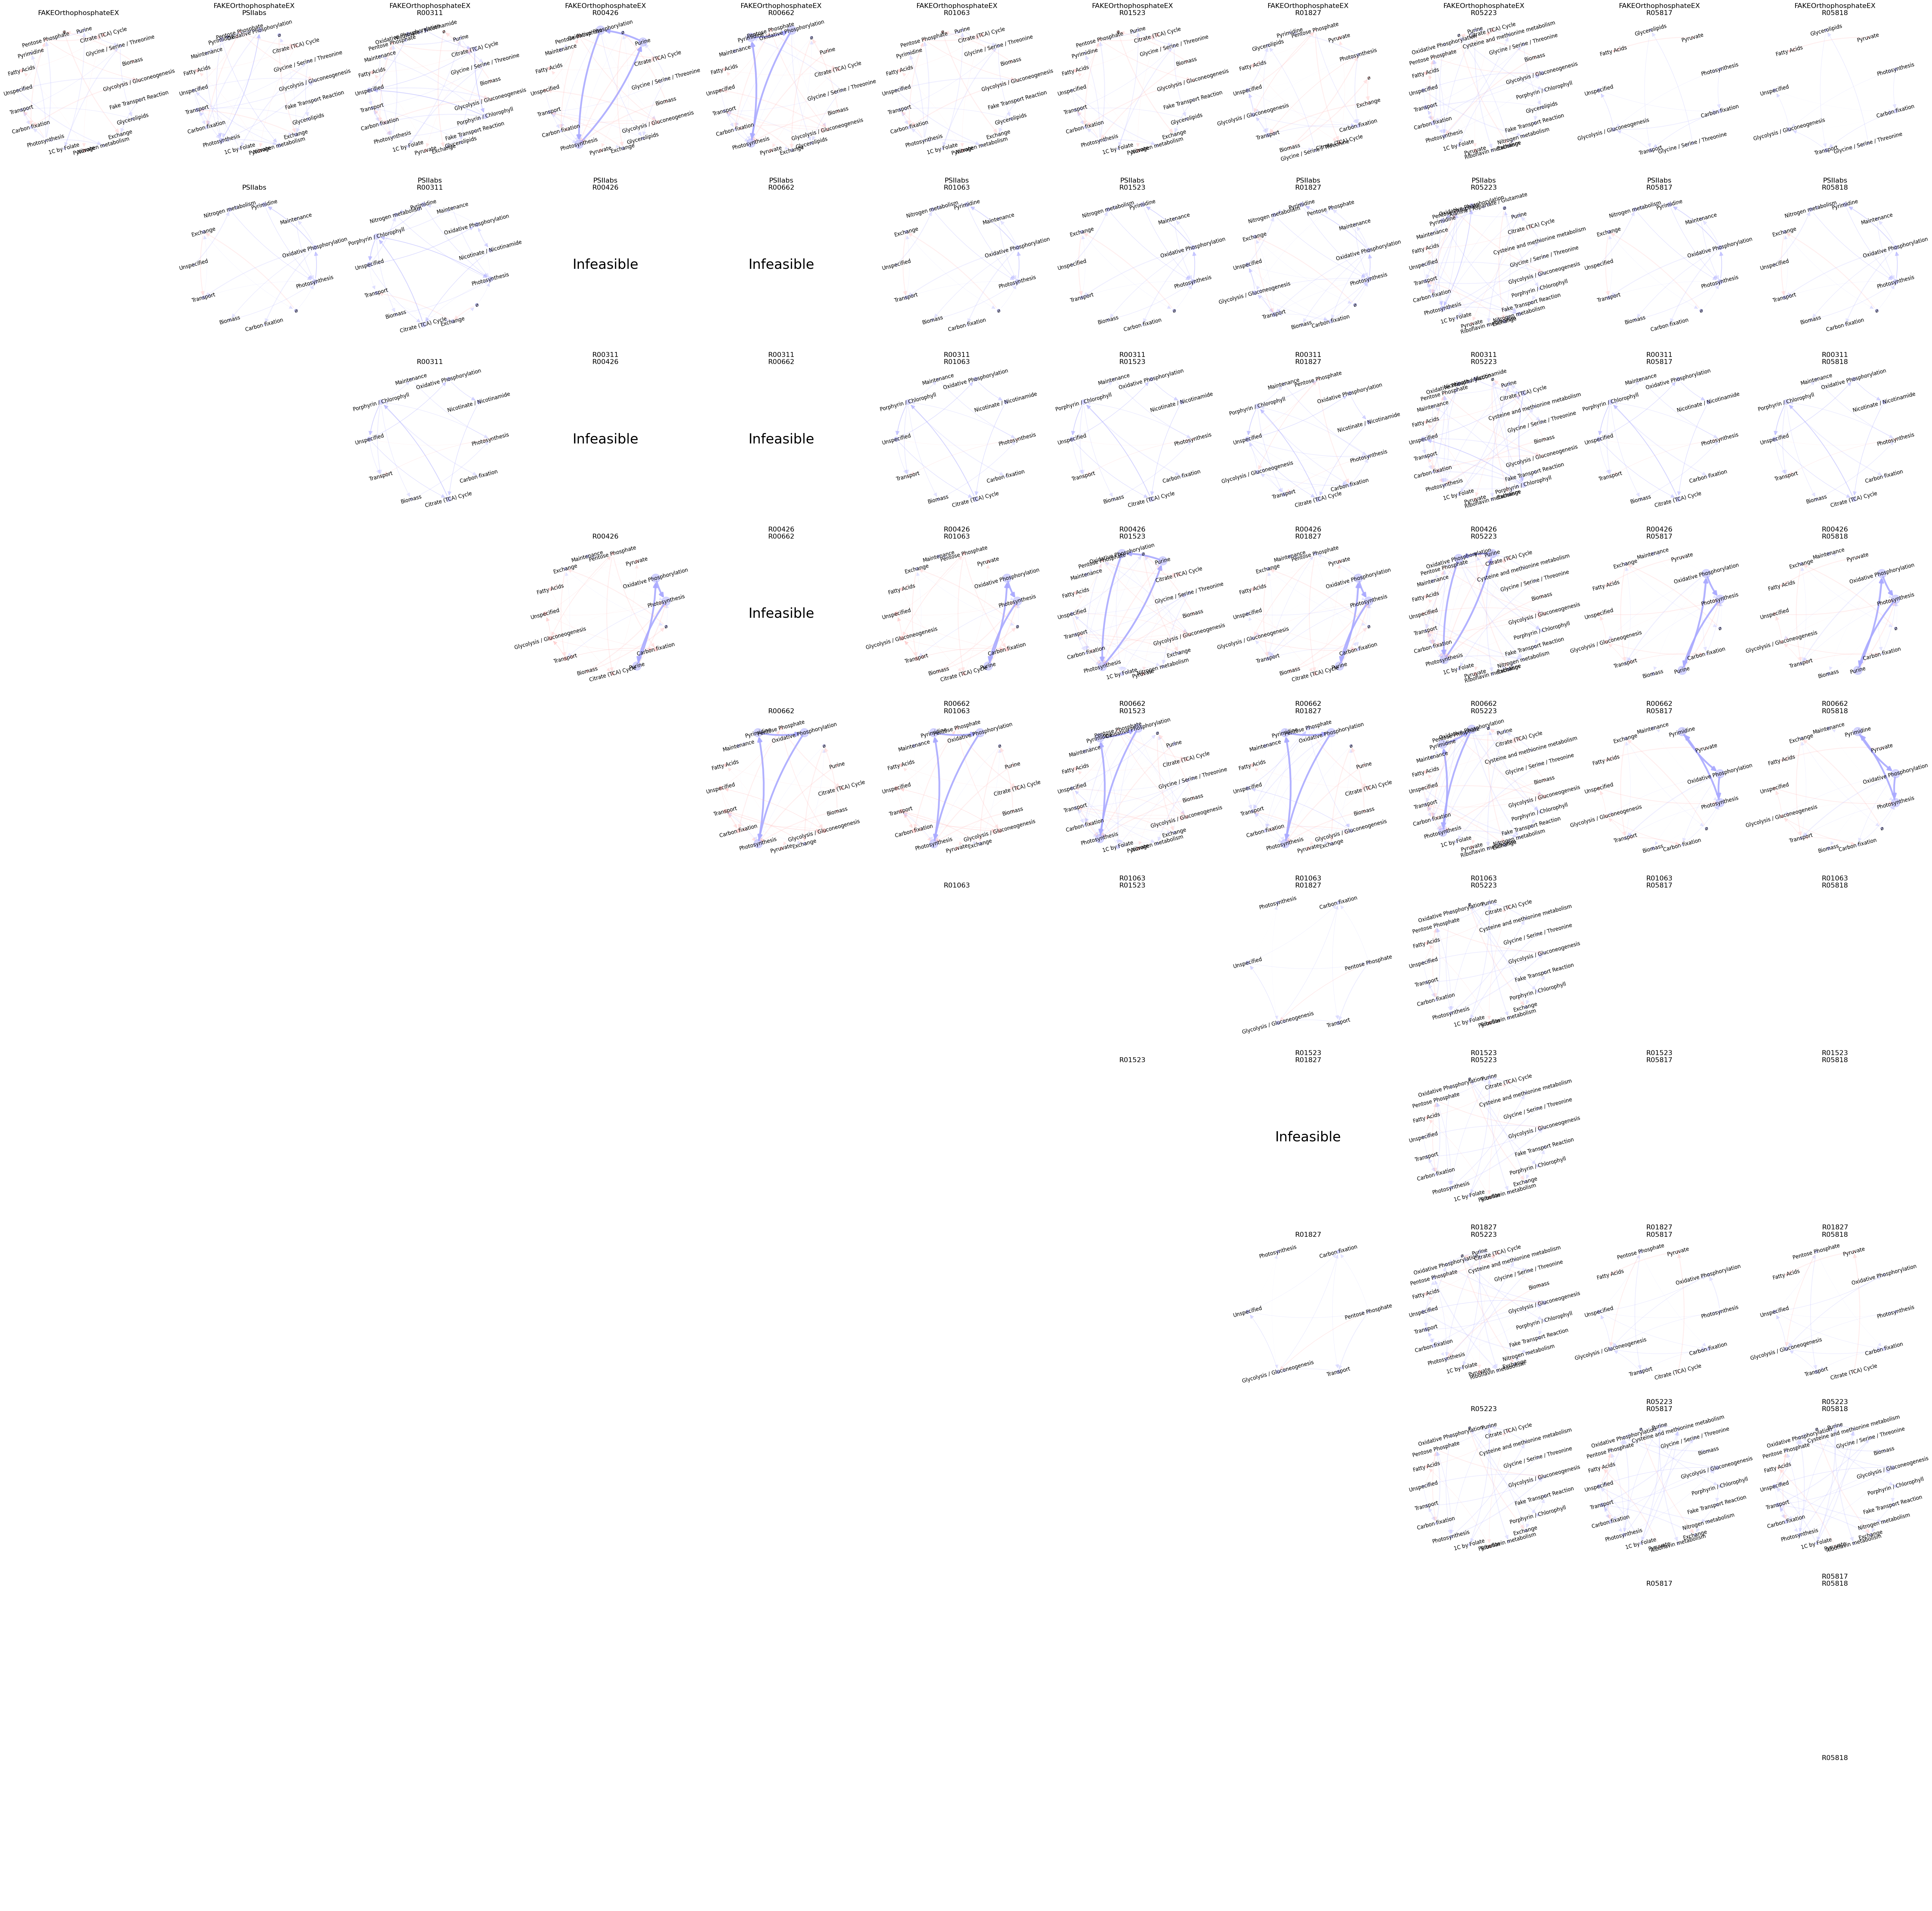

In [17]:
fig, axs = plt.subplots(11, 11, figsize=(80, 80))
graphs = {}
for ax in axs.flatten():
    ax.xaxis.set_ticks_position("none")
    ax.yaxis.set_ticks_position("none")
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)

for (i, amg1), (j, amg2) in combinations_with_replacement(enumerate(sorted(amgs)), 2):
    with model as smodel:
        ax = axs[i][j]

        smodel.reactions.get_by_id(amg1).bounds = amg_limits_dict[amg1]
        smodel.reactions.get_by_id(amg2).bounds = amg_limits_dict[amg2]
        smoma = cobra.flux_analysis.moma(smodel, baseline)

        ax.xaxis.set_ticks_position("none")
        ax.yaxis.set_ticks_position("none")
        ax.xaxis.set_major_locator(plt.NullLocator())
        ax.yaxis.set_major_locator(plt.NullLocator())

        if smoma.status == "optimal":
            go = gu.subsystem_flux_graph(smodel, baseline, masses=masses)
            gp = gu.subsystem_flux_graph(smodel, smoma, masses=masses)
            gd = gu.diff_graph(gp, go)
            graphs[(amg1, amg2)] = (gp, go, gd)
            draw_graph(gd, ax, cut=30 / 300, manual_relabels=manual_relabels, scale=300)
        else:
            ax.annotate(
                "Infeasible",
                xy=(0.5, 0.5),
                xytext=(0.5, 0.5),
                fontsize=32,
                horizontalalignment="center",
                verticalalignment="center",
            )
        if i != j:
            ax.set_title(f"{amg1}\n{amg2}", fontsize=16)
        else:
            ax.set_title(f"{amg1}", fontsize=16)
        print(amg1, amg2, smoma.status)
plt.show()

In [18]:
syn = {}
for (amg1, amg2), (gp, go, gd) in graphs.items():
    if amg1 == amg2:
        continue
    g1 = graphs[(amg1, amg1)][-1]
    g2 = graphs[(amg2, amg2)][-1]
    diff_from_additive = gu.diff_graph(gu.diff_graph(gd, g1), g2)

    msd = np.mean([d["weight"] ** 2 for _, _, d in diff_from_additive.edges(data=True)])
    # msd = np.mean(
    #     [diff_from_additive.in_degree(u) ** 2 for u in diff_from_additive.nodes()]
    # )
    syn[(amg1, amg2)] = msd

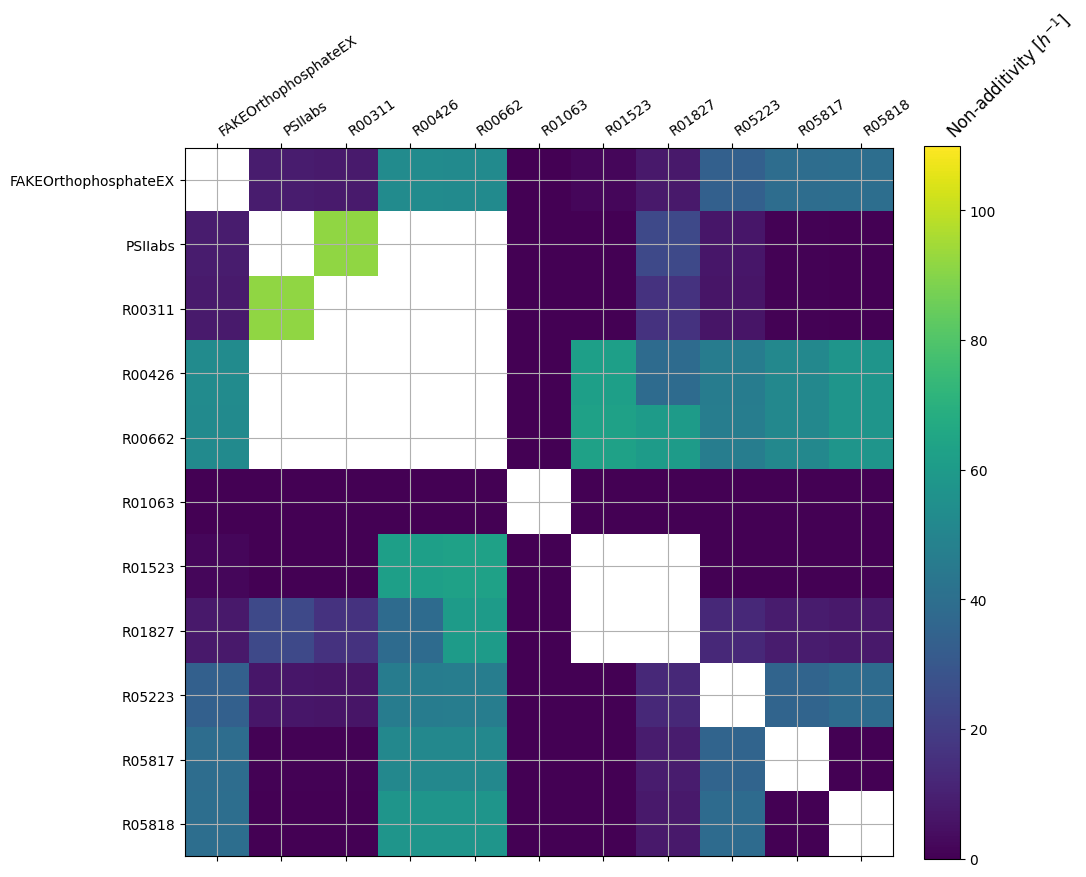

In [19]:
synmat = np.full([11, 11], np.nan)

for (i, amg1), (j, amg2) in combinations_with_replacement(enumerate(sorted(amgs)), 2):
    if (amg1, amg2) in syn:
        synmat[i][j] = syn[(amg1, amg2)]
        synmat[j][i] = syn[(amg1, amg2)]

fig, ax = plt.subplots(figsize=(10, 10))
h = ax.matshow(np.sqrt(synmat), vmin=0, vmax=110)
ax.set_xticks(np.arange(11))
ax.set_yticks(np.arange(11))
ax.set_xticklabels(sorted(amgs), rotation=35, ha="left")
ax.set_yticklabels(sorted(amgs))
ax.grid(True)
cb = fig.colorbar(h, ax=ax, fraction=0.046, pad=0.04)
cb.ax.set_title(r"Non-additivity [$h^{-1}$]", rotation=45, ha="left")
plt.show()

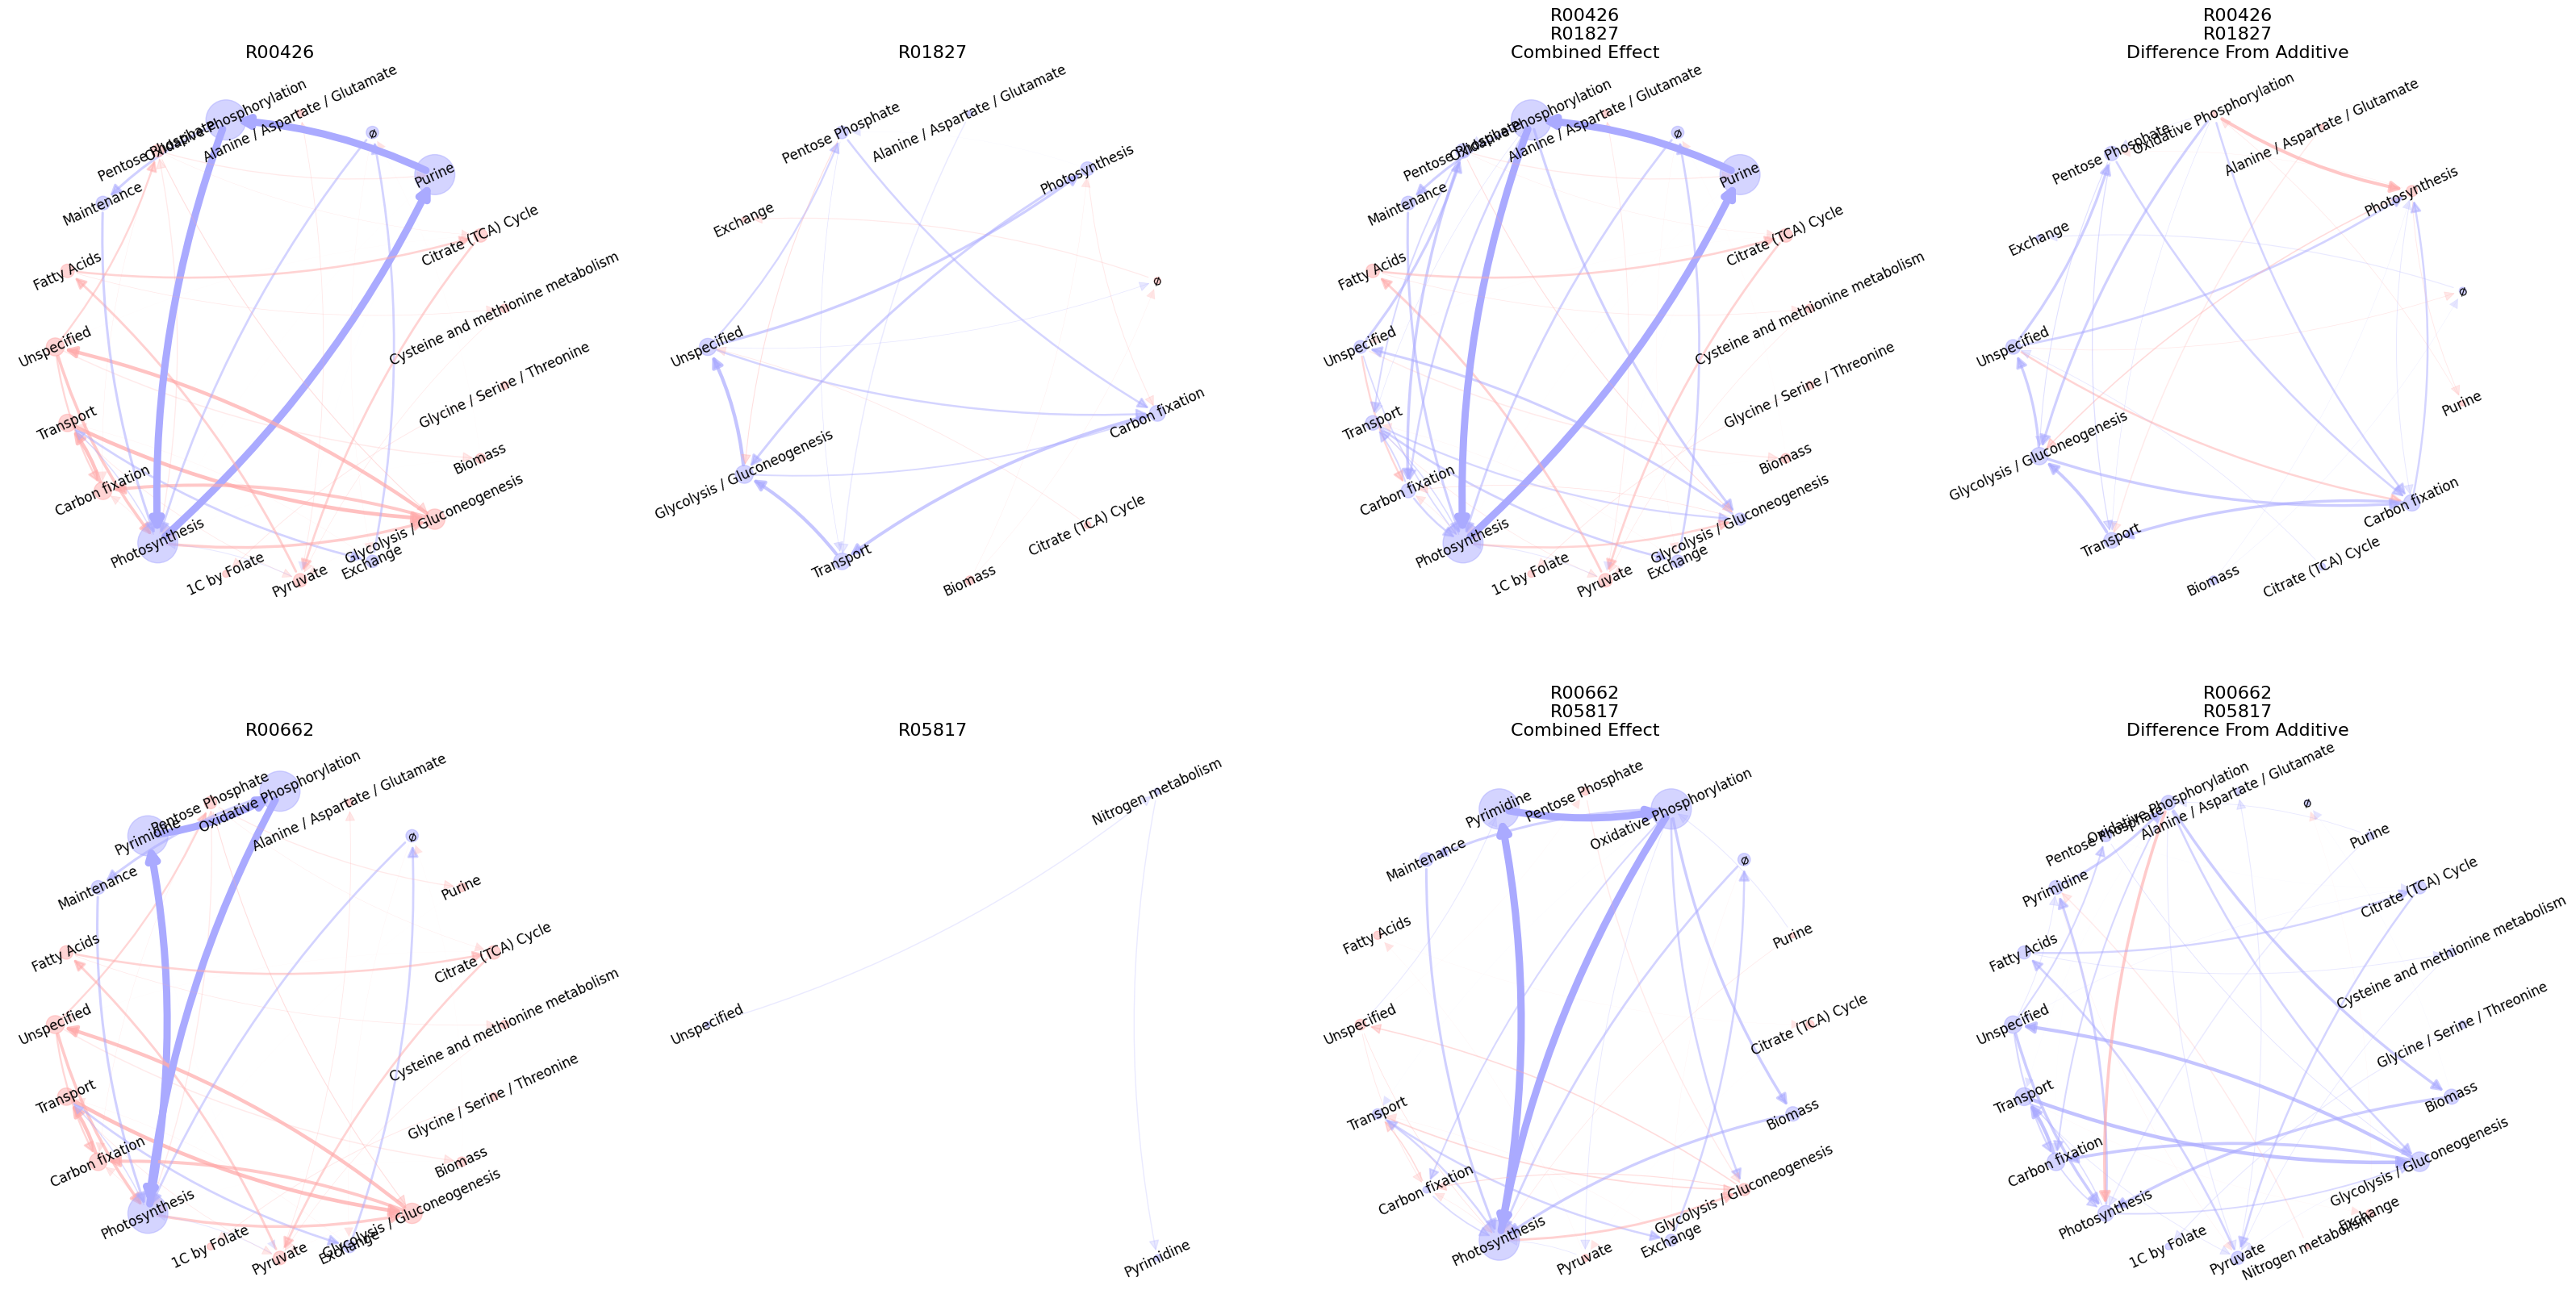

In [20]:
fscale = 10
fig, axs = plt.subplots(2, 4, figsize=(4 * fscale, 2 * fscale))

for ax in axs.flatten():
    ax.xaxis.set_ticks_position("none")
    ax.yaxis.set_ticks_position("none")
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)

order = [
    ((0, "R00426"), (0, "R00426")),
    ((0, "R01827"), (1, "R01827")),
    ((0, "R00426"), (2, "R01827")),
    ((0, "R00426"), (3, "R01827")),
    ((1, "R00662"), (0, "R00662")),
    ((1, "R05817"), (1, "R05817")),
    ((1, "R00662"), (2, "R05817")),
    ((1, "R00662"), (3, "R05817")),
]

for (i, amg1), (j, amg2) in order:
    ax = axs[i][j]

    ax.xaxis.set_ticks_position("none")
    ax.yaxis.set_ticks_position("none")
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    if (amg1, amg2) in graphs:
        (gp, go, gd) = graphs[(amg1, amg2)]
        scale = 30
        if j != 3:
            gd2 = gd
        else:
            g1 = graphs[(amg1, amg1)][-1]
            g2 = graphs[(amg2, amg2)][-1]
            gd2 = gu.diff_graph(gu.diff_graph(gd, g1), g2)
        draw_graph(
            gd2,
            ax,
            cut=10 / scale,
            manual_relabels=manual_relabels,
            scale=scale,
            label_rotation=25,
        )
    else:
        ax.annotate(
            "Infeasible",
            xy=(0.5, 0.5),
            xytext=(0.5, 0.5),
            fontsize=32,
            horizontalalignment="center",
            verticalalignment="center",
        )
    if amg1 != amg2:
        if j != 3:
            ax.set_title(f"{amg1}\n{amg2}\nCombined Effect", fontsize=16)
        else:
            ax.set_title(f"{amg1}\n{amg2}\nDifference From Additive", fontsize=16)
    else:
        ax.set_title(f"{amg1}", fontsize=16)
plt.show()